# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**: Lauren Michel

**ID**: LAM425

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/BEE4750/hw2-lam425`
Precompiling project...
  ✓ StatsAPI
  ✓ LaTeXStrings
  ✓ WorkerUtilities
  ✓ Contour
  ✓ CommonSolve
  ✓ InverseFunctions
  ✓ ConcurrentUtilities
  ✓ SentinelArrays
  ✓ Preferences
  ✓ Compat
  ✓ OrderedCollections
  ✓ CompositionsBase
  ✓ MbedTLS
  ✓ URIs
  ✓ Formatting
  ✓ ExceptionUnwrapping
  ✓ InvertedIndices
  ✓ ConstructionBase
  ✓ MacroTools
  ✓ DataAPI
  ✓ TranscodingStreams
  ✓ BitFlags
  ✓ Scratch
  ✓ LoggingExtras
  ✓ LogExpFunctions
  ✓ Crayons
  ✓ InverseFunctions → DatesExt
  ✓ PrecompileTools
  ✓ JLLWrappers
  ✓ Compat → CompatLinearAlgebraExt
  ✓ CompositionsBase → CompositionsBaseInverseFunctionsExt
  ✓ PooledArrays
  ✓ FixedPointNumbers
  ✓ Missings
  ✓ Tables
  ✓ CodecZlib
  ✓ RelocatableFolders
  ✓ RecipesBase
  ✓ Latexify
  ✓ StringManipulation
  ✓ Graphite2_jll
  ✓ OpenSSL_jll
  ✓ Libmount_jll
  ✓ EpollShim_jll
  ✓ LLVMOpenMP_jll
  ✓ Bzip2_jll
  ✓ Xorg_libXau_jll
  ✓ libpng_jll
  ✓ libfdk_aac_jll
  ✓ LAME_jl

In [4]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

> **Tip**
>
> Formulate your model in terms of distance downriver, rather than
> leaving it in terms of time from discharge.

I'm putting this on the pdf that I'm submitting, as I wrote it down by hand.

### Problem 2 (25 points)

Consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t, \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.

**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

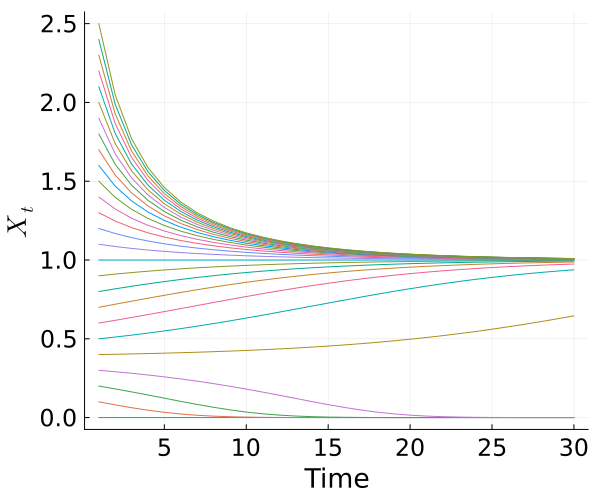

In [26]:
lake_P_cycling(x, q) = x.^q ./ (1 .+ x.^q);
lake_P_out(x, b) = b .* x;

T = 30
X_vals = collect(0.0:0.1:2.5)
function simulate_lake_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t].+ lake_P_cycling(X[t-1], q) .- lake_P_out(X[t-1], b)
    end
    return X
end
X = map(x -> simulate_lake_P(x, T, 0.5, 1.5, zeros(T), zeros(T)), X_vals)
p_noinflow = plot(X, label=false, ylabel=L"X_t", xlabel="Time", guidefontsize=18, tickfontsize=16, size=(600, 500))

In [65]:
#Using the Roots.find_zero function had some issues, so I did something a little different

lake_P_cycling(x, q) = x.^q ./ (1 .+ x.^q);
lake_P_out(x, b) = b .* x;

T = 30
X_vals = collect(0.0:0.1:2.5)
function change(X_ic, T, b, q, a, y)
    X = zeros(T)
    delta = zeros(T)
    delta[1] = 10
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t].+ lake_P_cycling(X[t-1], q) .- lake_P_out(X[t-1], b)
        #array with the changes in X values
        delta[t] = X[t]-X[t-1]
        #if change between the two X values is very small, return the X value (where the equilibrium is)
        if delta[t]<10^-3
            return X[t]
        end
    end
    return delta
end

change (generic function with 1 method)

In [57]:
change(.25, T, 0.5, 1.5, zeros(T), zeros(T))

0.2361111111111111

The eqilibria of this function are at $X_t = 0.0$ and $X_t =1.0$. These equilibria are stable, which means that the resilience of the system is strong. There is a bit of instability when $X_t$ is a little less than 0.5 and $t = 0$, which could make a tipping point if $X_t$ were to vary slightly and a disturbance could alter the system outcomes.

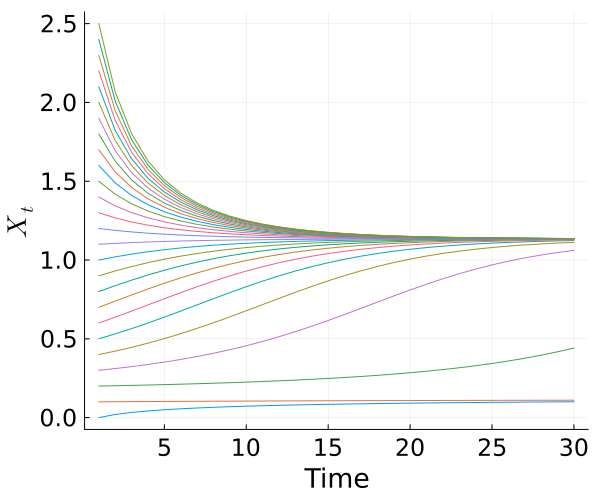

In [33]:
lake_P_cycling(x, q) = x.^q ./ (1 .+ x.^q);
lake_P_out(x, b) = b .* x;

T = 30
X_vals = collect(0.0:0.1:2.5)
function simulate_lake_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t].+ lake_P_cycling(X[t-1], q) .- lake_P_out(X[t-1], b)
    end
    return X
end
X = map(x -> simulate_lake_P(x, T, 0.5, 1.5, zeros(T), 0.02*ones(T)), X_vals)
p_noinflow = plot(X, label=false, ylabel=L"X_t", xlabel="Time", guidefontsize=18, tickfontsize=16, size=(600, 500))

In [69]:
change(1, T, 0.5, 1.5, zeros(T), 0.02*ones(T))

1.129744495594354

The new equilibria are slightly greater than when $a_t$ equaled 0, being where $X_t$ is slightly greater than 0 (around 0.096) and $X_t$ is slighlty greater than 1 (around 1.13). Additionally, the moment of instability is now around $X_t = 0.25$, which is less than it was when $a_t$ equaled 0. Also, the range of $X_t$ values that converge to the lower equilibrium around $X_t = 0$ is much smaller than it was when $a_t$ equaled 0, whereas the range of $X_t$ values that converge to the equilibrium around $X_t = 1$ is greater. This means the system is more likely to result in $X_t$ equaling something close to 1, and this result is more resilient.

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.